This notebook will describe experiments related to DUD-E

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


import sys
sys.path.append("/g/g13/jones289/workspace/hd-cuda-master/hdpy")


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1")
range_limit = 1


# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/123")
# range_limit = 1


In [4]:
list(data_p.glob("dude.random*.pkl"))[0].name

'dude.random.hivpr.smiles-pe.atomwise.0.pkl'

In [5]:
dude_target_names = list(set([x.name.split('.')[2] for x in list(data_p.glob("dude.random*.pkl"))]))
dude_target_names

['parp1',
 'aces',
 'fa10',
 'inha',
 'dyr',
 'hivpr',
 'mcr',
 'sahh',
 'aldr',
 'bace1',
 'pnph',
 'vgfr2',
 'mk14',
 'comt',
 'kith',
 'pgh2',
 'try1',
 'cdk2',
 'pde5a',
 'egfr',
 'pur2',
 'ace',
 'pgh1',
 'thrb',
 'ada',
 'hs90a',
 'esr1',
 'prgr',
 'gcr',
 'hmdh',
 'ampc',
 'pygm',
 'src',
 'pparg',
 'andr',
 'rxra',
 'nram',
 'hivrt']

In [6]:
def compute_average_enrichment(pkl_path, model):
    range_limit=1
    enrich_1_list = [] 
    enrich_10_list = []
    

    
    with open(pkl_path, "rb") as handle:
        
        print (pkl_path)
        data = pickle.load(handle) # lets just use one seed

    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):
#             print(seed)

            if isinstance(data[seed]["y_true"], np.ndarray):
                y_true = data[seed]["y_true"]
            else:
                y_true = np.concatenate(data[seed]["y_true"]) 
            y_pred = np.array(data[seed]["y_pred"])

    
            eta = np.array(data[seed]["eta"])

            if np.unique(y_true).shape[0] < 2 :
                metric = 0
            else:
                metric = recall_score(y_pred=y_pred, y_true=y_true)
                if model in ["rf", "mlp"]:
                    eta= eta[:, 1]

            enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
            enrich_1_list.append(enrich_1)
                
            enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
            enrich_10_list.append(enrich_10)
            
    
    return np.mean(enrich_1_list), np.std(enrich_1_list), np.mean(enrich_10_list), np.std(enrich_10_list)




def compute_average_train_time(pkl_path):
    
    range_limit = 1
    print(pkl_path)
    train_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        target = pkl_path.name.split(".")[2]
        split = pkl_path.name.split(".")[1]
        model = pkl_path.name.split(".")[3]

    
#         if "openhd" in model:
#             range_limit=1
        for seed in range(range_limit):

            train_time = 0
            if model in ["ecfp", "rp", "selfies", "smiles-pe", "atomwise"]:
                train_time = data[seed]["retrain_time"]
            else:
                
                train_time  = data[seed]["train_time"]

            if "openhd" in model:
                pass
            
            elif "mlp" in model:
                train_time = train_time / 10 # trained MLP for max 10 epochs...check that it hits that but assume it didn't converge that quickly
            elif "rf" in model:
                train_time = train_time # there's no concept of epoch in a random forest
            else:
                train_time = train_time/10 # this should catch all HD models which were trained for 10 epochs per seed
            
            train_time_list.append(train_time)
            
            
    
    return np.mean(train_time_list)



def compute_average_inference_time(pkl_path):
    
    test_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        

    
#         if "openhd" in str(pkl_path):
#             range_limit=1
        for seed in range(range_limit):

            test_time  = data[seed]["test_time"]

            test_time_list.append(test_time)
            
            
    
    return np.mean(test_time_list)


def get_train_test_sizes(pkl_path):
    
    train_size_list = []
    test_size_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
    
#         if "openhd" in str(pkl_path):
#             range_limit=1
        for seed in range(range_limit):

            train_size_list.append(data[seed]["train_size"])
            test_size_list.append(data[seed]["test_size"])            
            
    
    return np.mean(train_size_list), np.mean(test_size_list)
                    

# DUD-E results

In [7]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [8]:
#     "openhd-ecfp": green_color_pal[6],

color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[2],
    "smiles-pe.bpe.0": rocket_color_pal[4],   
"selfies.atomwise": green_color_pal[4],
    "selfies.atomwise": green_color_pal[4],
    "openhd-ecfp": green_color_pal[5],
        "openhd-rp": green_color_pal[5],
    "ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
    "mlp": blue_color_pal[7],
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
    ("selfies.atomwise", "HDBind-SELFIES"),
    ("ecfp", "HDBind-ECFP"),
    ("openhd-ecfp", "OpenHD-ECFP"),
    ("openhd-rp", "OpenHD-RPFP"),
    ("rp", "HDBind-RPFP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
    ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.",
    "smiles-pe.bpe.0": "MoleHD-BPE",
    "selfies.atomwise": "HDBind-SELFIES",
    "ecfp": "HDBind-ECFP",
    "openhd-ecfp": "OPENHD-ECFP",
    "openhd-rp": "OPENHD-RPFP",
    "rp": "HDBind-RPFP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
 }

In [9]:
def aggregate_dude_results(dataset, split):
    
    model_metric_dict = {"model": [], "enrich-1-mean": [], 
                         "enrich-1-std":[], "enrich-10-mean": [], 
                         "enrich-10-std": [], "train_time":[], "test_time": [],
                        "train_size": [], "test_size": []}
    

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]

    for model, color in color_dict.items():
                        
        data_path_list = list(data_p.glob(f"{dataset}.{split}.*.{model}*pkl"))

        
        for path in tqdm(data_path_list, total=len(data_path_list)):
            
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
                
                
            enrich_1_mean, enrich_1_std, enrich_10_mean, enrich_10_std = compute_average_enrichment(path, model=model)
            train_time_mean = compute_average_train_time(path)
            test_time_mean = compute_average_inference_time(path)
            train_size, test_size = get_train_test_sizes(path)
            
            
            model_metric_dict["model"].append(model)
            model_metric_dict["enrich-1-mean"].append(enrich_1_mean)
            model_metric_dict["enrich-1-std"].append(enrich_1_std)
            model_metric_dict["enrich-10-mean"].append(enrich_10_mean)
            model_metric_dict["enrich-10-std"].append(enrich_10_std)
            model_metric_dict["train_time"].append(train_time_mean)
            model_metric_dict["test_time"].append(test_time_mean)
            model_metric_dict["train_size"].append(train_size)
            model_metric_dict["test_size"].append(test_size)


    return enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.smiles-pe.atomwise.0.pkl


  3%|▎         | 1/38 [00:00<00:13,  2.69it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.smiles-pe.atomwise.0.pkl


 13%|█▎        | 5/38 [00:00<00:03,  8.49it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.smiles-pe.atomwise.0.pkl


 21%|██        | 8/38 [00:01<00:04,  6.69it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.smiles-pe.atomwise.0.pkl


 29%|██▉       | 11/38 [00:01<00:03,  8.63it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.smiles-pe.atomwise.0.pkl


 32%|███▏      | 12/38 [00:01<00:03,  7.37it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.smiles-pe.atomwise.0.pkl


 34%|███▍      | 13/38 [00:01<00:03,  7.20it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.smiles-pe.atomwise.0.pkl


 37%|███▋      | 14/38 [00:02<00:04,  5.40it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.smiles-pe.atomwise.0.pkl


 39%|███▉      | 15/38 [00:02<00:04,  5.10it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.smiles-pe.atomwise.0.pkl


 42%|████▏     | 16/38 [00:02<00:04,  5.26it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.smiles-pe.atomwise.0.pkl


 47%|████▋     | 18/38 [00:02<00:03,  6.39it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.smiles-pe.atomwise.0.pkl


 50%|█████     | 19/38 [00:03<00:03,  5.74it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.smiles-pe.atomwise.0.pkl


 58%|█████▊    | 22/38 [00:03<00:02,  6.50it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.smiles-pe.atomwise.0.pkl


 61%|██████    | 23/38 [00:03<00:02,  5.98it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.smiles-pe.atomwise.0.pkl


 63%|██████▎   | 24/38 [00:03<00:02,  5.25it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.smiles-pe.atomwise.0.pkl


 71%|███████   | 27/38 [00:04<00:01,  7.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.smiles-pe.atomwise.0.pkl


 76%|███████▋  | 29/38 [00:04<00:00,  9.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.smiles-pe.atomwise.0.pkl


 82%|████████▏ | 31/38 [00:04<00:00,  9.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.smiles-pe.atomwise.0.pkl


 87%|████████▋ | 33/38 [00:05<00:00,  5.97it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.smiles-pe.atomwise.0.pkl


 89%|████████▉ | 34/38 [00:05<00:00,  5.68it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.smiles-pe.atomwise.0.pkl


 97%|█████████▋| 37/38 [00:05<00:00,  6.93it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.smiles-pe.atomwise.0.pkl


100%|██████████| 38/38 [00:06<00:00,  6.32it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.smiles-pe.atomwise.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.smiles-pe.bpe.0.pkl


  3%|▎         | 1/38 [00:00<00:05,  6.51it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.smiles-pe.bpe.0.pkl


  5%|▌         | 2/38 [00:00<00:06,  5.23it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.smiles-pe.bpe.0.pkl


  8%|▊         | 3/38 [00:00<00:08,  4.26it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.smiles-pe.bpe.0.pkl


 13%|█▎        | 5/38 [00:00<00:05,  6.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.smiles-pe.bpe.0.pkl


 18%|█▊        | 7/38 [00:01<00:04,  6.43it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.smiles-pe.bpe.0.pkl


 24%|██▎       | 9/38 [00:01<00:04,  7.05it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.smiles-pe.bpe.0.pkl


 29%|██▉       | 11/38 [00:01<00:03,  8.34it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.smiles-pe.bpe.0.pkl


 34%|███▍      | 13/38 [00:01<00:03,  7.22it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.smiles-pe.bpe.0.pkl


 39%|███▉      | 15/38 [00:02<00:02,  9.54it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.smiles-pe.bpe.0.pkl


 47%|████▋     | 18/38 [00:02<00:02,  7.46it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.smiles-pe.bpe.0.pkl


 55%|█████▌    | 21/38 [00:02<00:01,  8.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.smiles-pe.bpe.0.pkl


 61%|██████    | 23/38 [00:03<00:01,  8.18it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.smiles-pe.bpe.0.pkl


 66%|██████▌   | 25/38 [00:03<00:01,  8.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.smiles-pe.bpe.0.pkl


 68%|██████▊   | 26/38 [00:03<00:01,  6.96it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.smiles-pe.bpe.0.pkl


 74%|███████▎  | 28/38 [00:03<00:01,  6.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.smiles-pe.bpe.0.pkl


 79%|███████▉  | 30/38 [00:04<00:01,  7.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.smiles-pe.bpe.0.pkl


 82%|████████▏ | 31/38 [00:04<00:01,  6.70it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.smiles-pe.bpe.0.pkl


 84%|████████▍ | 32/38 [00:04<00:01,  5.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.smiles-pe.bpe.0.pkl


 89%|████████▉ | 34/38 [00:04<00:00,  5.89it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.smiles-pe.bpe.0.pkl


 92%|█████████▏| 35/38 [00:05<00:00,  5.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.smiles-pe.bpe.0.pkl


 95%|█████████▍| 36/38 [00:05<00:00,  5.61it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.smiles-pe.bpe.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.selfies.atomwise.0.pkl


  8%|▊         | 3/38 [00:00<00:04,  7.56it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.selfies.atomwise.0.pkl


 13%|█▎        | 5/38 [00:00<00:04,  6.68it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.selfies.atomwise.0.pkl


 18%|█▊        | 7/38 [00:00<00:03,  8.57it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.selfies.atomwise.0.pkl


 24%|██▎       | 9/38 [00:01<00:03,  7.67it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.selfies.atomwise.0.pkl


 29%|██▉       | 11/38 [00:01<00:03,  6.96it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.selfies.atomwise.0.pkl


 32%|███▏      | 12/38 [00:01<00:03,  7.13it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.selfies.atomwise.0.pkl


 39%|███▉      | 15/38 [00:01<00:02,  9.08it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.selfies.atomwise.0.pkl


 47%|████▋     | 18/38 [00:02<00:02,  8.43it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.selfies.atomwise.0.pkl


 55%|█████▌    | 21/38 [00:02<00:02,  7.56it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.selfies.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:03<00:01,  8.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.selfies.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:03<00:01,  6.92it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.selfies.atomwise.0.pkl


 71%|███████   | 27/38 [00:03<00:01,  5.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.selfies.atomwise.0.pkl


 79%|███████▉  | 30/38 [00:04<00:01,  7.07it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.selfies.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:04<00:00,  7.54it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.selfies.atomwise.0.pkl


 87%|████████▋ | 33/38 [00:04<00:00,  5.85it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.selfies.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:04<00:00,  6.30it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.selfies.atomwise.0.pkl


 95%|█████████▍| 36/38 [00:05<00:00,  6.07it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.selfies.atomwise.0.pkl


100%|██████████| 38/38 [00:05<00:00,  6.84it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.selfies.atomwise.0.pkl


0it [00:00, ?it/s]
0it [00:00, ?it/s]
  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.ecfp.atomwise.0.pkl


  5%|▌         | 2/38 [00:00<00:03, 10.44it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.ecfp.atomwise.0.pkl


 11%|█         | 4/38 [00:00<00:02, 13.25it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.ecfp.atomwise.0.pkl


 16%|█▌        | 6/38 [00:00<00:04,  7.24it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.ecfp.atomwise.0.pkl


 24%|██▎       | 9/38 [00:01<00:03,  7.49it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.ecfp.atomwise.0.pkl


 29%|██▉       | 11/38 [00:01<00:03,  7.87it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.ecfp.atomwise.0.pkl


 32%|███▏      | 12/38 [00:01<00:03,  7.23it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.ecfp.atomwise.0.pkl


 34%|███▍      | 13/38 [00:01<00:05,  4.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.ecfp.atomwise.0.pkl


 39%|███▉      | 15/38 [00:02<00:03,  6.97it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.ecfp.atomwise.0.pkl


 42%|████▏     | 16/38 [00:02<00:03,  5.96it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.ecfp.atomwise.0.pkl


 47%|████▋     | 18/38 [00:02<00:03,  5.66it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.ecfp.atomwise.0.pkl


 50%|█████     | 19/38 [00:02<00:03,  6.16it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.ecfp.atomwise.0.pkl


 58%|█████▊    | 22/38 [00:03<00:02,  7.69it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.ecfp.atomwise.0.pkl


 61%|██████    | 23/38 [00:03<00:02,  6.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.ecfp.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:03<00:02,  6.10it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.ecfp.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:03<00:02,  5.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.ecfp.atomwise.0.pkl


 71%|███████   | 27/38 [00:04<00:02,  5.07it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.ecfp.atomwise.0.pkl


 74%|███████▎  | 28/38 [00:04<00:01,  5.18it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.ecfp.atomwise.0.pkl


 79%|███████▉  | 30/38 [00:04<00:01,  5.77it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.ecfp.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:04<00:00,  6.86it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.ecfp.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:05<00:00,  7.24it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.ecfp.atomwise.0.pkl


100%|██████████| 38/38 [00:05<00:00,  6.73it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.ecfp.atomwise.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.rp.atomwise.0.pkl


  5%|▌         | 2/38 [00:00<00:04,  8.17it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.rp.atomwise.0.pkl

 11%|█         | 4/38 [00:00<00:02, 11.83it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.rp.atomwise.0.pkl


 16%|█▌        | 6/38 [00:00<00:03,  9.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.rp.atomwise.0.pkl


 21%|██        | 8/38 [00:00<00:02, 11.02it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.rp.atomwise.0.pkl


 29%|██▉       | 11/38 [00:01<00:03,  7.85it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.rp.atomwise.0.pkl


 32%|███▏      | 12/38 [00:01<00:04,  5.72it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.rp.atomwise.0.pkl


 34%|███▍      | 13/38 [00:01<00:04,  5.06it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.rp.atomwise.0.pkl


 37%|███▋      | 14/38 [00:02<00:04,  4.89it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.rp.atomwise.0.pkl


 42%|████▏     | 16/38 [00:02<00:04,  5.08it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.rp.atomwise.0.pkl


 45%|████▍     | 17/38 [00:02<00:04,  5.03it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.rp.atomwise.0.pkl


 47%|████▋     | 18/38 [00:02<00:03,  5.23it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.rp.atomwise.0.pkl


 50%|█████     | 19/38 [00:03<00:04,  4.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.rp.atomwise.0.pkl


 55%|█████▌    | 21/38 [00:03<00:03,  5.25it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.rp.atomwise.0.pkl


 58%|█████▊    | 22/38 [00:03<00:03,  4.64it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.rp.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:04<00:01,  6.64it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.rp.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:04<00:01,  6.29it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.rp.atomwise.0.pkl


 74%|███████▎  | 28/38 [00:04<00:01,  6.08it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.rp.atomwise.0.pkl


 79%|███████▉  | 30/38 [00:04<00:01,  7.16it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.rp.atomwise.0.pkl


 82%|████████▏ | 31/38 [00:05<00:01,  6.42it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.rp.atomwise.0.pkl


 89%|████████▉ | 34/38 [00:05<00:00,  8.15it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.rp.atomwise.0.pkl


 95%|█████████▍| 36/38 [00:05<00:00,  8.53it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.rp.atomwise.0.pkl


100%|██████████| 38/38 [00:05<00:00,  6.54it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.rp.atomwise.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.rf.None.0.pkl


  3%|▎         | 1/38 [00:00<00:07,  4.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.rf.None.0.pkl


 11%|█         | 4/38 [00:00<00:04,  7.34it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.rf.None.0.pkl


 16%|█▌        | 6/38 [00:00<00:04,  7.63it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.rf.None.0.pkl


 21%|██        | 8/38 [00:01<00:04,  7.47it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.rf.None.0.pkl


 29%|██▉       | 11/38 [00:01<00:03,  8.17it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.rf.None.0.pkl


 37%|███▋      | 14/38 [00:01<00:02,  9.33it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.rf.None.0.pkl


 39%|███▉      | 15/38 [00:01<00:02,  8.15it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.rf.None.0.pkl


 47%|████▋     | 18/38 [00:02<00:02,  9.55it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.rf.None.0.pkl


 53%|█████▎    | 20/38 [00:02<00:01, 10.04it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.rf.None.0.pkl


 58%|█████▊    | 22/38 [00:02<00:01, 10.26it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.rf.None.0.pkl


 66%|██████▌   | 25/38 [00:02<00:01,  9.02it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.rf.None.0.pkl


 71%|███████   | 27/38 [00:03<00:01,  7.39it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.rf.None.0.pkl


 79%|███████▉  | 30/38 [00:03<00:00,  8.88it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.rf.None.0.pkl


 82%|████████▏ | 31/38 [00:03<00:00,  7.86it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.rf.None.0.pkl


 87%|████████▋ | 33/38 [00:03<00:00,  9.64it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.rf.None.0.pkl


 92%|█████████▏| 35/38 [00:04<00:00,  9.26it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.rf.None.0.pkl


100%|██████████| 38/38 [00:04<00:00,  8.53it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.rf.None.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.mlp.None.0.pkl


  3%|▎         | 1/38 [00:00<00:05,  6.48it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.fa10.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.bace1.mlp.None.0.pkl


  8%|▊         | 3/38 [00:00<00:04,  7.67it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.mlp.None.0.pkl


 11%|█         | 4/38 [00:00<00:05,  6.38it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.cdk2.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.mlp.None.0.pkl


 13%|█▎        | 5/38 [00:00<00:05,  6.44it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.gcr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.src.mlp.None.0.pkl


 21%|██        | 8/38 [00:01<00:04,  7.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.comt.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ada.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.mlp.None.0.pkl


 24%|██▎       | 9/38 [00:01<00:04,  6.28it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mk14.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.sahh.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.mlp.None.0.pkl


 29%|██▉       | 11/38 [00:01<00:03,  7.46it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ace.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pparg.mlp.None.0.pkl


 34%|███▍      | 13/38 [00:01<00:03,  6.73it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.vgfr2.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.mlp.None.0.pkl


 39%|███▉      | 15/38 [00:02<00:02,  8.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hs90a.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.nram.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.kith.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.mlp.None.0.pkl


 45%|████▍     | 17/38 [00:02<00:02,  8.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivpr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.try1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.mlp.None.0.pkl


 55%|█████▌    | 21/38 [00:02<00:01, 10.98it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.mcr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pur2.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aldr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.ampc.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.mlp.None.0.pkl


 61%|██████    | 23/38 [00:02<00:01, 10.99it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.esr1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.prgr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.mlp.None.0.pkl


 66%|██████▌   | 25/38 [00:03<00:01,  8.88it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pde5a.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.aces.mlp.None.0.pkl


 71%|███████   | 27/38 [00:03<00:01,  8.45it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.thrb.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.mlp.None.0.pkl


 74%|███████▎  | 28/38 [00:03<00:01,  8.62it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pnph.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pgh2.mlp.None.0.pkl


 82%|████████▏ | 31/38 [00:03<00:00,  9.46it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.inha.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.andr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hmdh.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.parp1.mlp.None.0.pkl


 92%|█████████▏| 35/38 [00:04<00:00,  9.21it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.rxra.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.pygm.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.hivrt.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.mlp.None.0.pkl


 97%|█████████▋| 37/38 [00:04<00:00,  8.58it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.egfr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1/dude.random.dyr.mlp.None.0.pkl


100%|██████████| 38/38 [00:04<00:00,  8.14it/s]


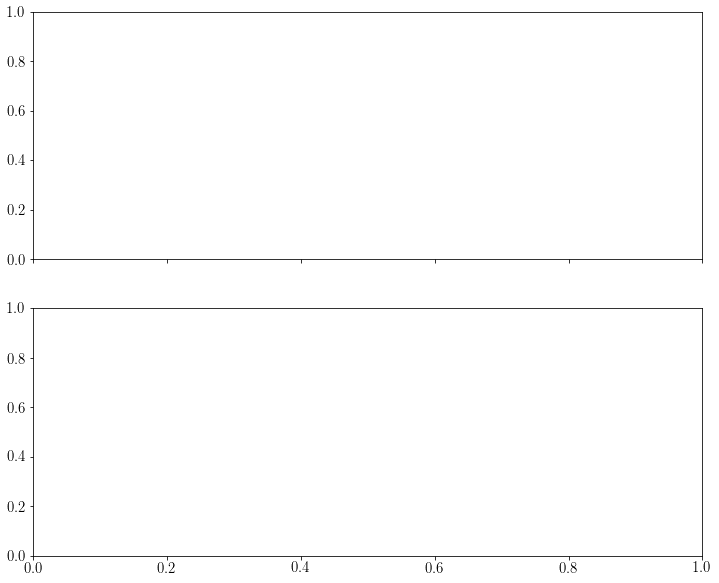

In [10]:
dude_enrich_f, dude_enrich_1_ax, dude_enrich_10_ax, model_metric_dict = aggregate_dude_results(dataset="dude", split="random")


In [11]:
model_metric_dict.keys()

dict_keys(['model', 'enrich-1-mean', 'enrich-1-std', 'enrich-10-mean', 'enrich-10-std', 'train_time', 'test_time', 'train_size', 'test_size'])

In [12]:
[(x[0], len(x[1])) for x in model_metric_dict.items()]

[('model', 266),
 ('enrich-1-mean', 266),
 ('enrich-1-std', 266),
 ('enrich-10-mean', 266),
 ('enrich-10-std', 266),
 ('train_time', 266),
 ('test_time', 266),
 ('train_size', 266),
 ('test_size', 266)]

In [13]:
model_metric_df = pd.DataFrame(model_metric_dict)

# for col in model_metric_df.columns:
#     model_model_metric_df[col].apply(lambda x: x[0])
#     model_metric_df[col].apply(lambda x: x[1])
#     model_metric_df[col].apply(lambda x: x[2])
    
# model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values],
#                                       "enrich-1": [tup[1] for tup in model_metric_df[col].values],
#                                       "enrich-10": [tup[2] for tup in model_metric_df[col].values]
#                                       "model": [col]*len(model_metric_df)} for col in model_metric_df.columns)]


# model_metric_df = pd.concat(model_metric_df_list)

# model_metric_df["latency"] = model_metric_df["test_time"] / model_metric_df["test_size"]

model_metric_df


,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size
0,smiles-pe.atomwise.0,55.000004,0.0,9.444445,0.0,4.951921,0.000329,23680.0,2970.0
1,smiles-pe.atomwise.0,62.555557,0.0,9.877193,0.0,0.968626,0.000298,4421.0,563.0
2,smiles-pe.atomwise.0,50.428574,0.0,8.404762,0.0,0.583727,0.000352,2861.0,353.0
3,smiles-pe.atomwise.0,58.000000,0.0,7.250000,0.0,0.397922,0.000341,1855.0,232.0
4,smiles-pe.atomwise.0,74.080002,0.0,9.851064,0.0,0.816334,0.000357,3697.0,463.0
...,...,...,...,...,...,...,...,...,...
261,mlp,62.555556,0.0,9.877193,0.0,1.410702,0.005505,4421.0,563.0
262,mlp,50.428571,0.0,9.805556,0.0,1.474520,0.003399,2861.0,353.0
263,mlp,7.350000,0.0,7.350000,0.0,0.098801,0.001518,1156.0,147.0
264,mlp,71.597384,0.0,9.761299,0.0,1.763929,0.036379,25336.0,3178.0


In [14]:
# model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
# model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

## Vina Docking baseline

In [15]:
vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")


color_dict.update({"Vina": "salmon"})



vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]


df_list = []


# root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
root_dude_dir = Path("/usr/workspace/atom/gbsa_modeling/dude_smiles/")
for idx, path in  enumerate(vina_path_list):
#     print(idx, path)
    target = path.name.split(".")[0].split("-")[0]
    print(target, idx+1, path)
    
    # for some reason don't have inactive data for abl1
    if target in ["abl1"]:
        continue
    if target in dude_target_names:
    
        active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
        active_df['y_true'] = [1] * len(active_df)
    
        decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
        decoy_df['y_true'] = [0] * len(decoy_df)
    
    
        target_df = pd.concat([active_df, decoy_df])
        
        target_df["target"] = [target] * len(target_df)
    
        target_df["vina"] = target_df[2]
        target_df["gbsa"] = target_df[3]
        
        target_df["cmpd_id"] = target_df[1]
        
        target_df["target_size"] = target_df.shape[0]
        
#         import pdb
#         pdb.set_trace()
        random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))
        
        
#         import pdb
#         pdb.set_trace()

        # we only use the scores from the test set to attempt an even comparison
    
        merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
        merged_df = merged_df.loc[merged_df['subset'] == "test"]

        print(merged_df.shape)
    
        df_list.append(merged_df)
    else:
        pass

df = pd.concat(df_list)
    

pgh1 1 /p/lustre1/jones289/DUDE-38/pgh1-active-summary.txt
(941, 11)
rxra 2 /p/lustre1/jones289/DUDE-38/rxra-active-summary.txt
(568, 11)
pnph 3 /p/lustre1/jones289/DUDE-38/pnph-active-summary.txt
(655, 11)
ampc 4 /p/lustre1/jones289/DUDE-38/ampc-active-summary.txt
(295, 11)
try1 5 /p/lustre1/jones289/DUDE-38/try1-active-summary.txt
(782, 11)
parp1 6 /p/lustre1/jones289/DUDE-38/parp1-active-summary.txt
(2673, 11)
comt 7 /p/lustre1/jones289/DUDE-38/comt-active-summary.txt
(406, 11)
andr 8 /p/lustre1/jones289/DUDE-38/andr-active-summary.txt
(643, 11)
sahh 9 /p/lustre1/jones289/DUDE-38/sahh-active-summary.txt
(336, 11)
ace 10 /p/lustre1/jones289/DUDE-38/ace-active-summary.txt
(1587, 11)
cdk2 11 /p/lustre1/jones289/DUDE-38/cdk2-active-summary.txt
(2604, 11)
fgfr1 12 /p/lustre1/jones289/DUDE-38/fgfr1-active-summary.txt
hmdh 13 /p/lustre1/jones289/DUDE-38/hmdh-active-summary.txt
(789, 11)
nram 14 /p/lustre1/jones289/DUDE-38/nram-active-summary.txt
(587, 11)
aces 15 /p/lustre1/jones289/DUDE-3

In [16]:
set(df['target'].values.tolist())

{'ace',
 'aces',
 'ada',
 'aldr',
 'ampc',
 'andr',
 'bace1',
 'cdk2',
 'comt',
 'dyr',
 'egfr',
 'esr1',
 'fa10',
 'gcr',
 'hivpr',
 'hivrt',
 'hmdh',
 'hs90a',
 'inha',
 'kith',
 'mcr',
 'mk14',
 'nram',
 'parp1',
 'pde5a',
 'pgh1',
 'pgh2',
 'pnph',
 'pparg',
 'prgr',
 'pur2',
 'pygm',
 'rxra',
 'sahh',
 'src',
 'thrb',
 'try1',
 'vgfr2'}

In [17]:
df

,0,1,2,3,y_true,target,vina,gbsa,cmpd_id,target_size,subset
65,158,CHEMBL178355,-7.3,-23.4889,1,pgh1,-7.3,-23.4889,CHEMBL178355,9475,test
68,161,CHEMBL283267,-7.7,-26.2514,1,pgh1,-7.7,-26.2514,CHEMBL283267,9475,test
69,162,CHEMBL184374,-7.1,-22.7434,1,pgh1,-7.1,-22.7434,CHEMBL184374,9475,test
79,171,CHEMBL433892,-7.3,-29.1098,1,pgh1,-7.3,-29.1098,CHEMBL433892,9475,test
90,180,CHEMBL404928,-6.6,-22.1502,1,pgh1,-6.6,-22.1502,CHEMBL404928,9475,test
...,...,...,...,...,...,...,...,...,...,...,...
8660,994,ZINC35141443,-7.8,-28.5967,0,gcr,-7.8,-28.5967,ZINC35141443,11247,test
8661,9941,ZINC08387402,-7.3,-5.9566,0,gcr,-7.3,-5.9566,ZINC08387402,11247,test
8678,9969,ZINC64795840,-7.4,-20.0953,0,gcr,-7.4,-20.0953,ZINC64795840,11247,test
8698,9992,ZINC02647100,-5.5,-11.0534,0,gcr,-5.5,-11.0534,ZINC02647100,11247,test


In [18]:
target_size_list = []
vina_enrich_1_list = []
vina_enrich_10_list = []

for target, target_df in df.groupby("target"):
    
    ef_1 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.01)
    ef_10 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.1)

    
    target_size_list.append(target_df.shape[0])
    
    vina_enrich_1_list.append(ef_1)
    vina_enrich_10_list.append(ef_10)
    
    
    print(f"{target}, {ef_1:.4f}\t{ef_10:.4f}\t{target_df.shape[0]}")
    
sorted_vina_enrich_1_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_1_list), key=lambda pair: pair[0])]
sorted_vina_enrich_10_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_10_list), key=lambda pair: pair[0])]



ace, 1.6811	1.3534	1587
aces, 12.2992	4.7184	2126
ada, 0.0000	0.2302	574
aldr, 3.5769	1.5330	837
ampc, 0.0000	1.2292	295
andr, 18.3714	2.9677	643
bace1, 3.6061	2.6398	1529
cdk2, 1.4183	1.7606	2604
comt, 0.0000	0.9002	406
dyr, 0.0000	1.7635	1459
egfr, 4.3677	2.2381	3219
esr1, 3.6968	2.2181	1597
fa10, 5.4376	2.1879	1687
gcr, 0.0000	2.3696	872
hivpr, 1.3017	3.1342	3087
hivrt, 0.0000	2.6167	157
hmdh, 0.0000	0.9665	789
hs90a, 0.0000	0.0000	466
inha, 0.0000	1.7438	211
kith, 0.0000	0.5402	282
mcr, 9.7333	3.8933	146
mk14, 7.4759	2.5798	3079
nram, 0.0000	0.0000	587
parp1, 10.4211	3.9371	2673
pde5a, 8.6297	2.4922	2223
pgh1, 0.0000	1.1006	941
pgh2, 4.0780	3.1823	1725
pnph, 5.1984	2.2054	655
pparg, 5.8793	4.6167	2265
prgr, 12.3974	4.0899	967
pur2, 6.1795	5.1908	241
pygm, 0.0000	0.9015	357
rxra, 18.9333	9.9649	568
sahh, 0.0000	0.0000	336
src, 3.2879	1.9727	2992
thrb, 4.9508	4.0506	880
try1, 2.7153	1.7873	782
vgfr2, 21.6409	4.8374	1864


I think it would be good to move away from the per-target (sorted by size) scatter plot and instead make a series of box plots...this should make it easier to compare the enrichment factors as you increase the amount of data that you are allowed to screen

In [19]:
model_metric_df = pd.concat([model_metric_df, pd.DataFrame({"metric": [0]*38, "enrich-1-mean": sorted_vina_enrich_1_list, 
                                            "enrich-10-mean": sorted_vina_enrich_10_list,
                                          "model": ["Vina"]*38, 
                                                           })])


model_metric_df

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric
0,smiles-pe.atomwise.0,55.000004,0.0,9.444445,0.0,4.951921,0.000329,23680.0,2970.0,NaN
1,smiles-pe.atomwise.0,62.555557,0.0,9.877193,0.0,0.968626,0.000298,4421.0,563.0,NaN
2,smiles-pe.atomwise.0,50.428574,0.0,8.404762,0.0,0.583727,0.000352,2861.0,353.0,NaN
3,smiles-pe.atomwise.0,58.000000,0.0,7.250000,0.0,0.397922,0.000341,1855.0,232.0,NaN
4,smiles-pe.atomwise.0,74.080002,0.0,9.851064,0.0,0.816334,0.000357,3697.0,463.0,NaN
...,...,...,...,...,...,...,...,...,...,...
33,Vina,10.421053,NaN,3.937058,NaN,NaN,NaN,NaN,NaN,0.0
34,Vina,3.287912,NaN,1.972747,NaN,NaN,NaN,NaN,NaN,0.0
35,Vina,7.475893,NaN,2.579807,NaN,NaN,NaN,NaN,NaN,0.0
36,Vina,1.301708,NaN,3.134209,NaN,NaN,NaN,NaN,NaN,0.0


In [20]:
sns.boxplot(data=model_metric_df[model_metric_df["model"].apply(lambda x: "openhd" not in x.lower())], x="model", y="enrich-1-mean", ax=dude_enrich_1_ax, palette=color_dict)
# dude_enrich_1_ax.set_title("(a) DUD-E Enrichment at 1\%", fontdict={"fontsize": 18})
dude_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)
dude_enrich_1_ax.set_xlabel("")
dude_enrich_1_ax.set_ylabel("EF")

# labels = [x[1] for x in model_order_list]

# dude_enrich_1_ax.set_xticklabels(labels)


Text(3.2000000000000135, 0.5, 'EF')

In [21]:
sns.boxplot(data=model_metric_df[model_metric_df["model"].apply(lambda x: "openhd" not in x.lower())], x="model", y="enrich-10-mean", ax=dude_enrich_10_ax, palette=color_dict)
# dude_enrich_10_ax.set_title("(b) DUD-E Enrichment at 10\%", fontdict={"fontsize": 18})

dude_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
# dude_enrich_10_ax.tick_params(axis="y")
dude_enrich_10_ax.set_xlabel("")
dude_enrich_10_ax.set_ylabel("EF")

labels = [model_name_dict[x.get_text()] for x in dude_enrich_10_ax.get_xticklabels()]
dude_enrich_10_ax.set_xticklabels(labels)


# # dude_enrich_10_ax.set_xticklabels(labels)
# plt.tight_layout()
dude_enrich_f.savefig("dude_enrich.png", dpi=600, bbox_inches="tight")


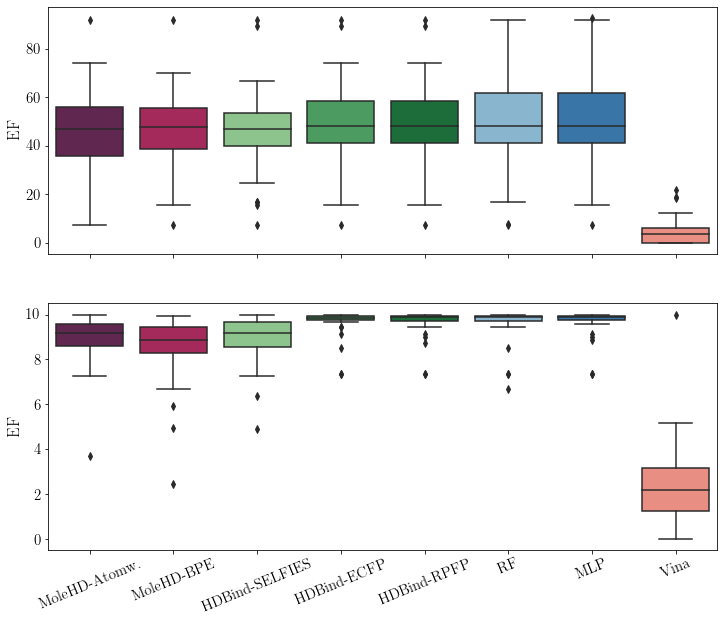

In [22]:
dude_enrich_f

In [23]:
model_metric_df[model_metric_df['model'] == "rp"].shape
for group_name, group_df in model_metric_df.groupby("model"):
    print(group_df.shape)

(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)
(38, 10)


In [24]:
model_metric_df.groupby('model').describe()[['enrich-1-mean', 'enrich-10-mean']]

enrich-1-mean                                         \
                             count       mean        std   min        25%   
model                                                                       
Vina                          38.0   4.665199   5.764932  0.00   0.000000   
ecfp                          38.0  48.956293  18.702387  7.35  41.018337   
mlp                           38.0  50.238817  20.203765  7.35  41.018336   
rf                            38.0  49.533835  19.757621  7.35  41.018336   
rp                            38.0  49.103719  18.804071  7.35  41.018337   
selfies.atomwise              38.0  45.661613  17.086972  7.35  39.721954   
smiles-pe.atomwise.0          38.0  45.672432  17.622445  7.35  35.680113   
smiles-pe.bpe.0               38.0  45.718331  17.152302  7.35  38.671399   

                                                      enrich-10-mean  \
                            50%        75%        max          count   
model                                                                  
Vina                   3.432418   6.104440  21.640867           38.0   
ecfp                  47.991762  58.395834  91.857140           38.0   
mlp                   47.991764  61.548611  92.600000           38.0   
rf                    47.991764  61.548611  91.857143           38.0   
rp                    47.991762  58.395834  91.857140           38.0   
selfies.atomwise      46.884266  53.409960  91.857140           38.0   
smiles-pe.atomwise.0  46.670637  55.758127  91.857140           38.0   
smiles-pe.bpe.0       47.499826  55.420002  91.857140           38.0   

                                                                        \
                          mean       std       min       25%       50%   
model                                                                    
Vina                  2.471403  1.886596  0.000000  1.260218  2.211721   
ecfp                  9.657814  0.614576  7.350000  9.737368  9.864129   
mlp                   9.679121  0.612173  7.350000  9.737368  9.900657   
rf                    9.606210  0.784033  6.666667  9.712698  9.900657   
rp                    9.660901  0.618676  7.350000  9.691888  9.900657   
selfies.atomwise      8.927373  1.087055  4.916667  8.570091  9.177028   
smiles-pe.atomwise.0  8.931635  1.133194  3.687500  8.605838  9.176147   
smiles-pe.bpe.0       8.441264  1.509483  2.458333  8.308388  8.863482   

                                           
                           75%        max  
model                                      
Vina                  3.170251   9.964912  
ecfp                  9.937364  10.000000  
mlp                   9.950733  10.000000  
rf                    9.950733  10.000000  
rp                    9.950733  10.000000  
selfies.atomwise      9.647379  10.000000  
smiles-pe.atomwise.0  9.584975   9.975000  
smiles-pe.bpe.0       9.441087   9.922078

In [25]:
model_metric_df.groupby('model').describe()[['enrich-1-std', 'enrich-10-std']]

enrich-1-std                                     \
                            count mean  std  min  25%  50%  75%  max   
model                                                                  
Vina                          0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
ecfp                         38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
mlp                          38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
rf                           38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
rp                           38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
selfies.atomwise             38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
smiles-pe.atomwise.0         38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
smiles-pe.bpe.0              38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                     enrich-10-std                                     
                             count mean  std  min  25%  50%  75%  max  
model                                                                  
Vina                           0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
ecfp                          38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
mlp                           38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
rf                            38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
rp                            38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
selfies.atomwise              38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
smiles-pe.atomwise.0          38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
smiles-pe.bpe.0               38.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [26]:
# model_metric_df.groupby('model').describe()['latency']['mean']['ecfp'] +\
# model_metric_df.groupby('model').describe()['latency']['mean']['rp'] +\
# model_metric_df.groupby('model').describe()['latency']['mean']['ecfp']

# OpenHD speedup

for now (03/15/23), the current openhd results are stored here: 

In [27]:
model_metric_df

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric
0,smiles-pe.atomwise.0,55.000004,0.0,9.444445,0.0,4.951921,0.000329,23680.0,2970.0,NaN
1,smiles-pe.atomwise.0,62.555557,0.0,9.877193,0.0,0.968626,0.000298,4421.0,563.0,NaN
2,smiles-pe.atomwise.0,50.428574,0.0,8.404762,0.0,0.583727,0.000352,2861.0,353.0,NaN
3,smiles-pe.atomwise.0,58.000000,0.0,7.250000,0.0,0.397922,0.000341,1855.0,232.0,NaN
4,smiles-pe.atomwise.0,74.080002,0.0,9.851064,0.0,0.816334,0.000357,3697.0,463.0,NaN
...,...,...,...,...,...,...,...,...,...,...
33,Vina,10.421053,NaN,3.937058,NaN,NaN,NaN,NaN,NaN,0.0
34,Vina,3.287912,NaN,1.972747,NaN,NaN,NaN,NaN,NaN,0.0
35,Vina,7.475893,NaN,2.579807,NaN,NaN,NaN,NaN,NaN,0.0
36,Vina,1.301708,NaN,3.134209,NaN,NaN,NaN,NaN,NaN,0.0


In [28]:
model_metric_df["latency_per_mol"] = model_metric_df.apply(lambda x: x["test_time"]/x["test_size"], axis=1)

In [29]:
model_metric_df[model_metric_df["model"] == "mlp"]

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric,latency_per_mol
228,mlp,32.840000,0.0,9.951515,0.0,1.805295,0.015592,13168.0,1642.0,NaN,0.000009
229,mlp,48.451613,0.0,9.947020,0.0,0.910126,0.008255,12019.0,1502.0,NaN,0.000005
230,mlp,44.428571,0.0,8.980243,0.0,0.713844,0.008933,7420.0,933.0,NaN,0.000010
231,mlp,72.828571,0.0,9.710476,0.0,28.491007,0.035668,20290.0,2549.0,NaN,0.000014
232,mlp,38.409091,0.0,9.941176,0.0,0.238889,0.008745,6758.0,845.0,NaN,0.000010
233,mlp,47.467742,0.0,9.976271,0.0,33.648171,0.037628,23591.0,2943.0,NaN,0.000013
234,mlp,66.500000,0.0,9.975000,0.0,1.101518,0.003962,3177.0,399.0,NaN,0.000010
235,mlp,89.166667,0.0,9.907407,0.0,0.413470,0.005715,4299.0,535.0,NaN,0.000011
236,mlp,49.688525,0.0,9.806946,0.0,10.221492,0.092416,24390.0,3031.0,NaN,0.000030
237,mlp,47.285714,0.0,9.735294,0.0,0.338556,0.010057,2660.0,331.0,NaN,0.000030


In [30]:
model_metric_df[model_metric_df["model"] == "ecfp"]

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time,train_size,test_size,metric,latency_per_mol
114,ecfp,47.285717,0.0,9.735294,0.0,0.537853,0.000363,2660.0,331.0,NaN,1.095573e-06
115,ecfp,48.451611,0.0,9.947020,0.0,2.550174,0.000294,12019.0,1502.0,NaN,1.958778e-07
116,ecfp,15.555555,0.0,10.000000,0.0,0.237486,0.000361,1108.0,140.0,NaN,2.578327e-06
117,ecfp,67.000000,0.0,9.925926,0.0,0.444329,0.000361,2130.0,268.0,NaN,1.346887e-06
118,ecfp,55.000004,0.0,9.814815,0.0,5.232301,0.000352,23680.0,2970.0,NaN,1.185671e-07
119,ecfp,38.409088,0.0,9.941176,0.0,1.417409,0.000305,6758.0,845.0,NaN,3.608726e-07
120,ecfp,49.688522,0.0,9.806946,0.0,5.056425,0.000297,24390.0,3031.0,NaN,9.785309e-08
121,ecfp,57.400002,0.0,9.896552,0.0,0.950352,0.000302,4565.0,574.0,NaN,5.258500e-07
122,ecfp,39.458332,0.0,9.137719,0.0,1.591821,0.000344,7582.0,947.0,NaN,3.635443e-07
123,ecfp,62.555557,0.0,9.877193,0.0,0.925645,0.000280,4421.0,563.0,NaN,4.975876e-07


In [31]:
for group_name, group_df in model_metric_df.groupby("model"):
    print(group_name, group_df.shape)


Vina (38, 11)
ecfp (38, 11)
mlp (38, 11)
rf (38, 11)
rp (38, 11)
selfies.atomwise (38, 11)
smiles-pe.atomwise.0 (38, 11)
smiles-pe.bpe.0 (38, 11)


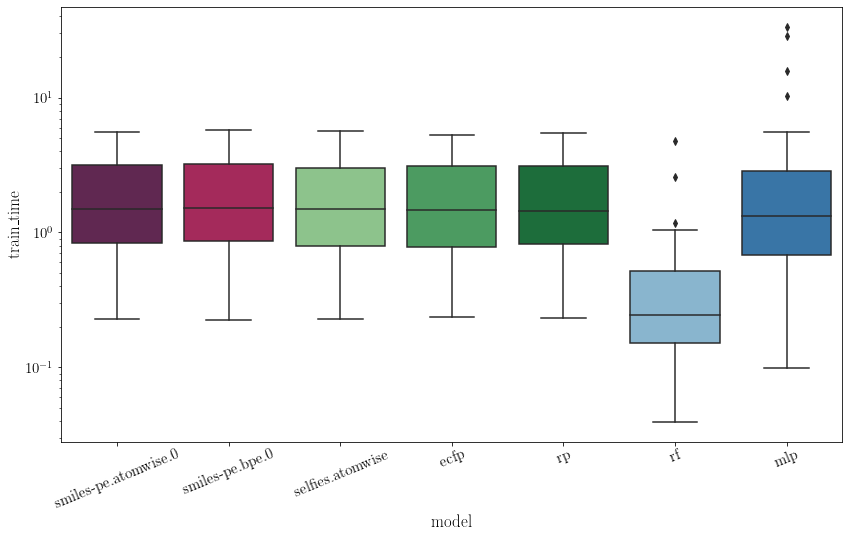

In [32]:
f, ax = plt.subplots(1,1, figsize=(14,8))

# for group_name, group_df in model_metric_df.groupby("model"):
#     sns.boxplot(data=group_df, x="train_time", ax=ax)
g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="train_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [33]:
group_dict = {group_name: group_df for group_name, group_df in model_metric_df.groupby('model')}

In [34]:
group_dict.keys()

dict_keys(['Vina', 'ecfp', 'mlp', 'rf', 'rp', 'selfies.atomwise', 'smiles-pe.atomwise.0', 'smiles-pe.bpe.0'])

In [35]:
# group_dict["rp"]["train_time"].mean() / group_dict["openhd-rp"]["train_time"].mean()

In [36]:
# group_dict["ecfp"]["train_time"].mean() / group_dict["openhd-ecfp"]["train_time"].mean()

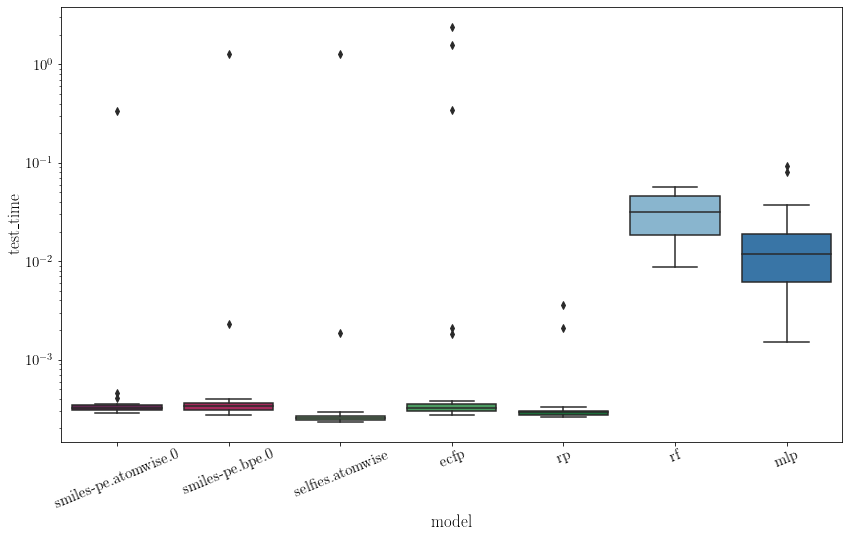

In [37]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="test_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [38]:
# sns.lineplot(data=model_metric_df, x="model", y="test_time")

In [39]:
group_dict["rf"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

2.6115224186583807e-05

In [40]:
group_dict["mlp"]["test_time"].mean() / group_dict["mlp"]["test_size"].mean()

1.415715472574189e-05

In [41]:
group_dict["ecfp"]["test_time"].mean() / group_dict["ecfp"]["test_size"].mean()

9.276680036917878e-05

In [42]:
group_dict["rp"]["test_time"].mean() / group_dict["rp"]["test_size"].mean()

3.4486592151386436e-07

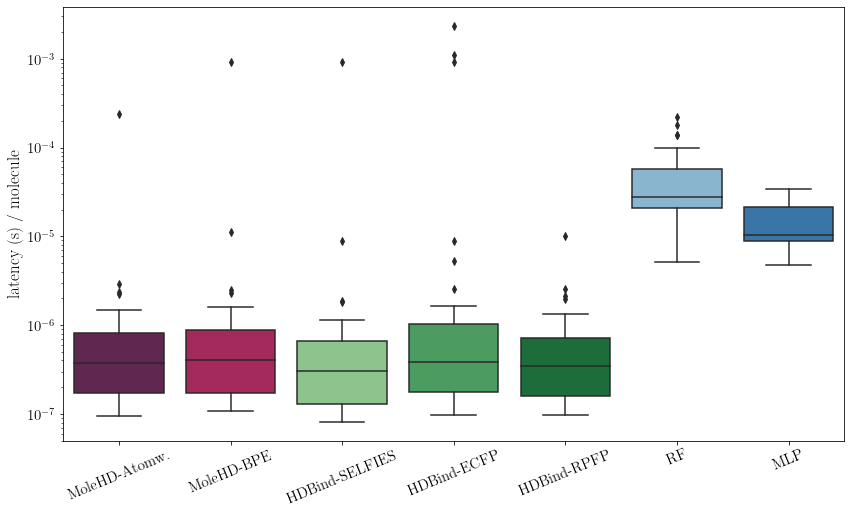

In [43]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="latency_per_mol", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

ax.set_ylabel("latency (s) / molecule")
ax.set_xlabel("")
labels = [model_name_dict[x.get_text()] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.savefig("dude_speedup.png", dpi=600, bbox_inches="tight")

In [44]:
group_dict["rf"]["latency_per_mol"].mean() / group_dict["rp"]["latency_per_mol"].mean()

60.279345187699654

In [45]:
group_dict["rf"]["latency_per_mol"].mean() / group_dict["ecfp"]["latency_per_mol"].mean()

0.41587807859193654

In [46]:
group_dict["rf"]["latency_per_mol"].mean() / group_dict["selfies.atomwise"]["latency_per_mol"].mean()

1.945555416117614

In [47]:
group_dict["rf"]["latency_per_mol"].mean() / group_dict["smiles-pe.atomwise.0"]["latency_per_mol"].mean()

7.003237939426028

In [48]:
group_dict["rf"]["latency_per_mol"].mean() / group_dict["smiles-pe.bpe.0"]["latency_per_mol"].mean()

1.9251243427940352

In [49]:
group_dict["rf"]["latency_per_mol"].median() / group_dict["mlp"]["latency_per_mol"].median()

2.6749758301953697

In [50]:
group_dict["rf"]["latency_per_mol"].median() / group_dict["rp"]["latency_per_mol"].median()

79.36621231298405

In [51]:
group_dict["rf"]["latency_per_mol"].median() / group_dict["ecfp"]["latency_per_mol"].median()

73.18279441647178

In [52]:
group_dict["rf"]["latency_per_mol"].median() / group_dict["selfies.atomwise"]["latency_per_mol"].median()

90.57242715099825

In [53]:
group_dict["rf"]["latency_per_mol"].median() / group_dict["smiles-pe.atomwise.0"]["latency_per_mol"].median()

73.3846691890625

In [54]:
group_dict["rf"]["latency_per_mol"].median() / group_dict["smiles-pe.bpe.0"]["latency_per_mol"].median()

67.88869045918152

In [55]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['latency_per_mol'].median()}")

Vina-nan
ecfp-3.799459022385631e-07
mlp-1.039467442622644e-05
rf-2.780550285290565e-05
rp-3.503443347309238e-07
selfies.atomwise-3.069974353955379e-07
smiles-pe.atomwise.0-3.7890070446825527e-07
smiles-pe.bpe.0-4.09574888907658e-07


/usr/workspace/wsa/jones289/miniconda3/envs/HD_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
